<a href="https://colab.research.google.com/github/ammarSherif/CIT690E-Deep-Learning-Labs/blob/main/Lab%206%3A%20Object%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Object Detection

CIT690E: Deep Learning <br>
Nile University<br>
Ammar Sherif<br>
Github Repo: [CIT690E-Deep-Learning-Labs](https://github.com/ammarSherif/CIT690E-Deep-Learning-Labs)

In [ ]:
# ==============================================================================
# Do some installations
# ==============================================================================
!pip install -q --upgrade selectivesearch torch_snippets
# ==============================================================================
# Some imports that we are using in our lab
# ==============================================================================
from torch_snippets import *
import selectivesearch
from skimage.segmentation import felzenszwalb

import torchvision
from torchvision import transforms,models,datasets
from torch.utils.data import Dataset, DataLoader
from torch_snippets import Report
from torchvision.ops import nms
from torchvision.ops import RoIPool
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

# import torch.nn as nn
# import torch
# import torch.nn.functional as F

# import matplotlib.pyplot as plt
# from PIL import Image
# import numpy as np
# from torch import optim
# import cv2, glob, numpy as np, pandas as pd
# import matplotlib.pyplot as plt
# from glob import glob
# import torchvision.transforms as transforms
# from torch.utils.data import DataLoader, Dataset

     |████████████████████████████████| 48 kB 2.6 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 60 kB 5.5 MB/s 
     |████████████████████████████████| 10.9 MB 32.0 MB/s 
     |████████████████████████████████| 229 kB 54.1 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 948 kB 44.5 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.


In [ ]:
# ==============================================================================
# Load the dataset; upload your kaggle.json token from your account, and run the
# below commands to load the dataset
# ==============================================================================
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

kaggle.json
 98% 361M/367M [00:02<00:00, 143MB/s]
100% 367M/367M [00:02<00:00, 135MB/s]


In [ ]:
# ==============================================================================
# Identify the device at the beginning
# ==============================================================================
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


## Evaluation Metric [IoU]

Before we go through the techniques to do object detection, we would like to know **how to evaluate** them first. We commonly use **Intersection over Union (IoU)**. Therefore, we have two boundary boxes: 
- true box, $T$
- detected box, $D$ 

We simply compute the IoU by just like what it seems; we compute the 
- **intersection**:  the area shared of the two
- **union**: the union of the areas of both the boxes

Finally, we just divide these values
$$\boxed{\texttt{IoU} = \frac{D \ \cap T}{D \ \cup T}}$$

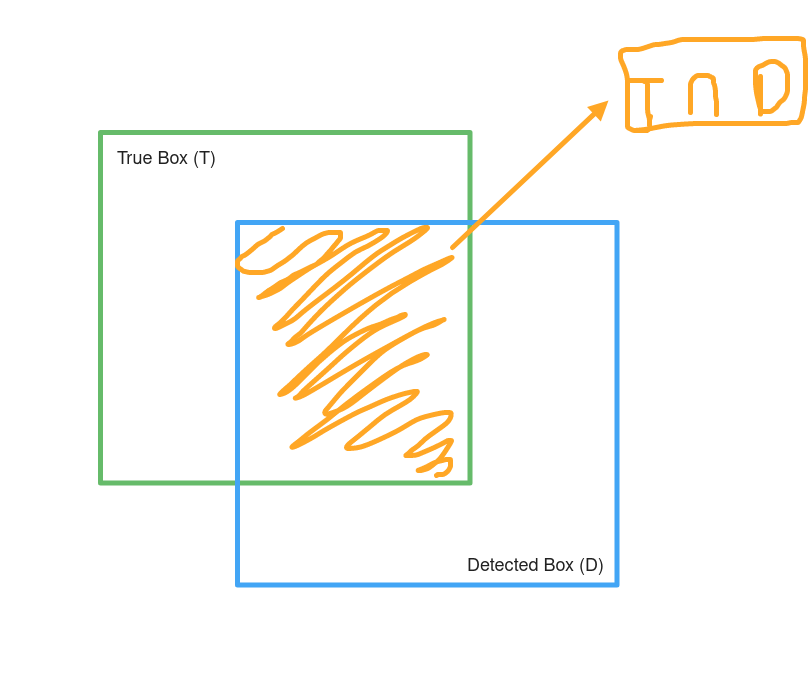

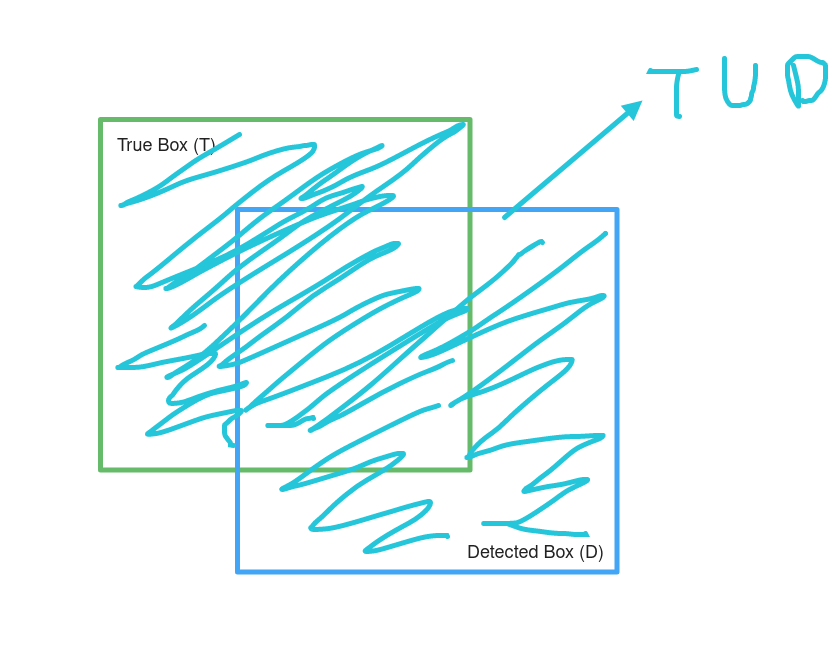

**Now let's think of the behavior of IoU in the extreme cases**

---

- What happens when we have a **perfect detection** $D=T$?<br>$$\texttt{IoU} = \frac{D \ \cap T}{D \ \cup T} = \frac{T}{T} = \boxed{1}$$
- What happens when we have a **worst detection** $D \cap T = \phi$?<br>$$\texttt{IoU} = \frac{D \ \cap T}{D \ \cup T} = \frac{0}{D \ \cup T} = \boxed{0}$$

Hence, we can see $$0 \leq \texttt{IoU} \leq 1$$

In [ ]:
# ==============================================================================
# Assume we have two boxes: D, T
# both are defined with 4-value tuple as below:
#   - v[0]: the x-axis value of the top left corner
#   - v[1]: the y-axis value of the top left corner
#   - v[3]: the x-axis value of the lower right corner
#   - v[4]: the y-axis value of the lower right corner
# ------------------------------------------------------------------------------
# because the denominator might be 0, we add a small value to avoid this
# ==============================================================================
def extract_iou(D, T):
    eps=1e-5
    # --------------------------------------------------------------------------
    # Compute the  points identifying the intersection;  the lowe corner is max,
    # while the upper right corner is the minimum.
    # --------------------------------------------------------------------------
    x1 = max(D[0], T[0])
    y1 = max(D[1], T[1])

    x2 = min(D[2], T[2])
    y2 = min(D[3], T[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    intersection = width * height
    area_D = (D[2] - D[0]) * (D[3] - D[1])
    area_T = (T[2] - T[0]) * (T[3] - T[1])
    # --------------------------------------------------------------------------
    # Union = the sum - intersection
    # --------------------------------------------------------------------------
    union = area_D + area_T - intersection
    iou = intersection / (union+eps)
    return iou

In [ ]:
A = (0,0,2,2)
B = (1,1,2,2)
C = (2,2,4,4)
# ==============================================================================
# Test our method
# ==============================================================================
print(f"Identical: {extract_iou(A,A):.2f}")
print(f"Disjoint: {extract_iou(A,C):.2f}")
print(f"Normal: {extract_iou(A,B):.2f}")

Identical: 1.00
Disjoint: 0.00
Normal: 0.25


## Dataset

We have already loaded this [dataset](https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks) from Kaggle 

In [ ]:
# ==============================================================================
# indicate the root, and check the labels
# ==============================================================================
IMAGE_ROOT = 'images/images'
DF_RAW = pd.read_csv('df.csv')
print(DF_RAW.head())

            ImageID  Source LabelName  Confidence      XMin      XMax  \
0  0000599864fd15b3  xclick       Bus           1  0.343750  0.908750   
1  00006bdb1eb5cd74  xclick     Truck           1  0.276667  0.697500   
2  00006bdb1eb5cd74  xclick     Truck           1  0.702500  0.999167   
3  00010bf498b64bab  xclick       Bus           1  0.156250  0.371250   
4  00013f14dd4e168f  xclick       Bus           1  0.287500  0.999375   

       YMin      YMax  IsOccluded  IsTruncated  ...  IsDepiction  IsInside  \
0  0.156162  0.650047           1            0  ...            0         0   
1  0.141604  0.437343           1            0  ...            0         0   
2  0.204261  0.409774           1            1  ...            0         0   
3  0.269188  0.705228           0            0  ...            0         0   
4  0.194184  0.999062           0            1  ...            0         0   

   XClick1X  XClick2X  XClick3X  XClick4X  XClick1Y  XClick2Y  XClick3Y  \
0  0.421875  0.34

In [ ]:
# ==============================================================================
# Create a wrapper to the dataset
# ==============================================================================
class OpenImages(Dataset):
    def __init__(self, df, image_folder=IMAGE_ROOT):
        self.root = image_folder
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}.jpg'
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path

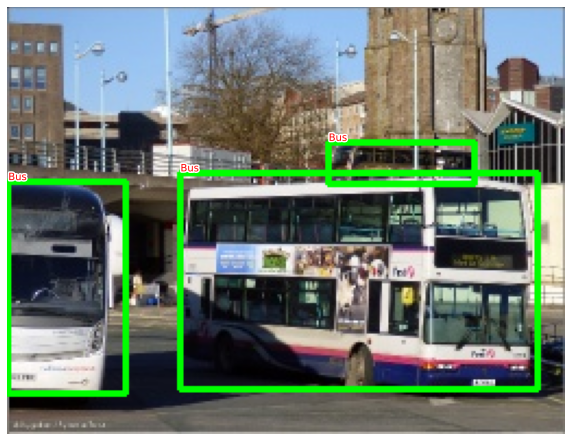

In [ ]:
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[25]
show(im, bbs=bbs, texts=clss, sz=10)

## History of Object Detection

Previously, there were some techniques proposed to do detection; mainly depend on **sliding window**. In brief, you move over sub-regions of the image, and do normal classification over each region. If we got 1 for bus, for example, then we know that this region of the image includes an object

**What is the problem of this approach?**
1. Generate sub-images depending on the sliding window
2. Classify each sub-image, using any classification method
----

- **Huge computation**
- shape invariance?<br>like what if the window does not match perfectly the object?

## Selective Search

The major problem was that huge computation, to fix it. They tried to **reduce that number of generated sub-images**, so reducing the overall computation needed to test them. There are multiple methods. Here, we mention one, which is using **selective search**.

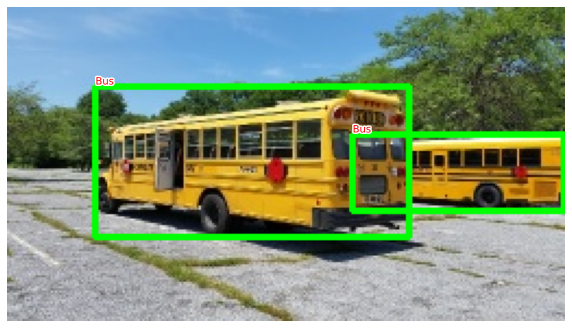

In [ ]:
img, bbs, clss, _ = ds[11]
show(img, bbs=bbs, texts=clss, sz=10)

In [ ]:
segments_fz = felzenszwalb(img, scale=200)

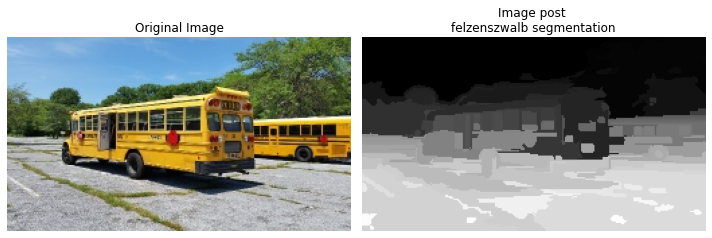

In [ ]:
# ==============================================================================
# Plot the image and after using felzenszwalb segmentation
# ==============================================================================
subplots([img, segments_fz], titles=['Original Image',
                                     'Image post \nfelzenszwalb segmentation'],
          figsize=(10,10), nc=2)

Now, check the **segmented image** on the right. We notice that based on the image intensities, we can be sure that there is no object in the top of the image, sky, as there is no change in intensity. As well, the bottom of it, so we can just detect the object in the middle. This is exactly what region based, and selective search does

<img src="https://i.imgur.com/DPEJcwI.png" alt="selective search algorithm">

[image source](https://donghwa-kim.github.io/SelectiveSearch.html)

In [ ]:
# ==============================================================================
# Use selective search to extract possible boundaries to check
# ==============================================================================
def extract_candidates(img, scale=200):
    img_lbl, regions = selectivesearch.selective_search(img, scale=scale, 
                                                        min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

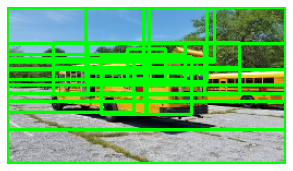

In [ ]:
candidates = extract_candidates(img,200)
show(img, bbs = candidates)

**Tip:**

-----
You can adjust the selective search algorithm based on the scale parameter as mentioned in the documentation <a href="https://github.com/AlpacaDB/selectivesearch#scale" target="_blank">selectivesearch Github</a>

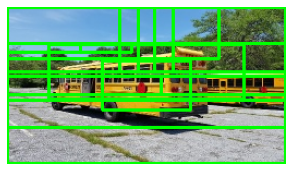

In [ ]:
candidates = extract_candidates(img,1000)
show(img, bbs = candidates)

Because these bounding regions are quite less than the generated ones if using sliding window, we can use these generated boxes to detect objects within them.

## R-CNN

Now, what if we got these generated regions, and used CNN architecture to classify whether this region is an object or not. This is exactly what Region CNN (RCNN) is.

**But is there a better, faster, approach?**

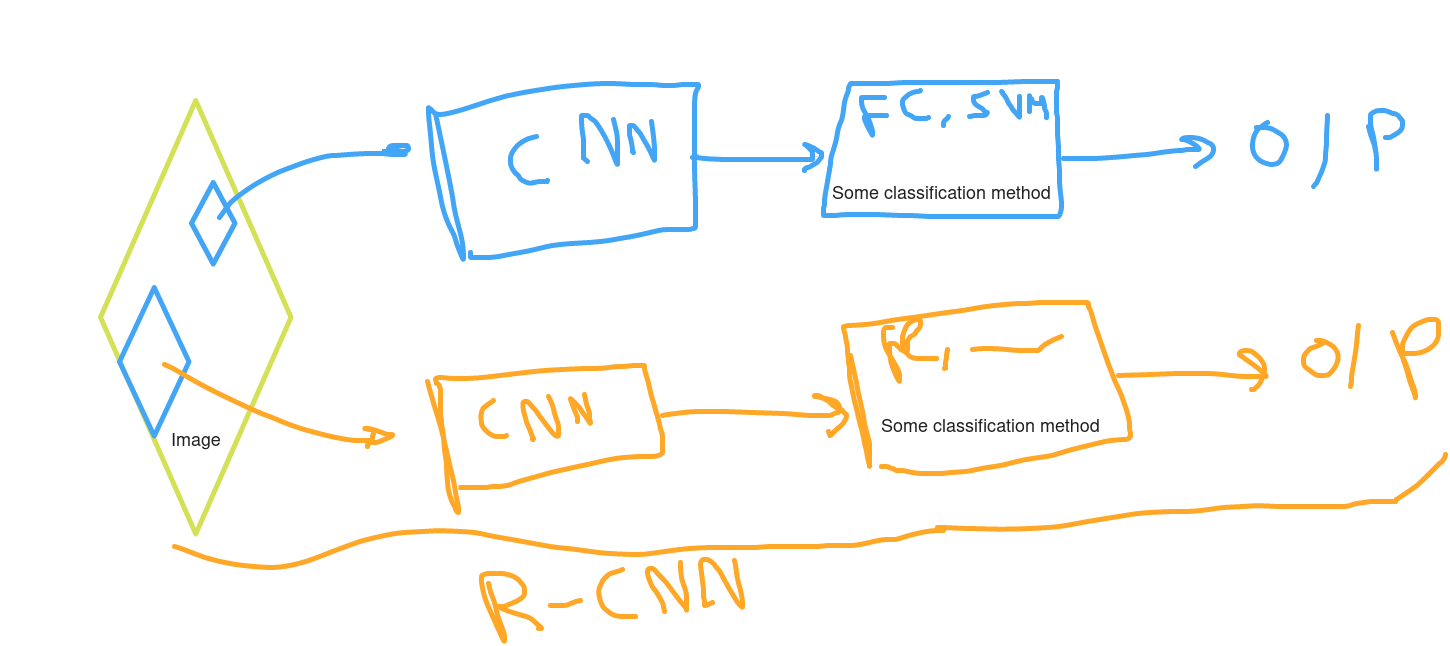

## Fast R-CNN

This of the scenario of the below image, **are not the shared region of the two boxes have the same convolution result?**

**Why should we compute them twice?**

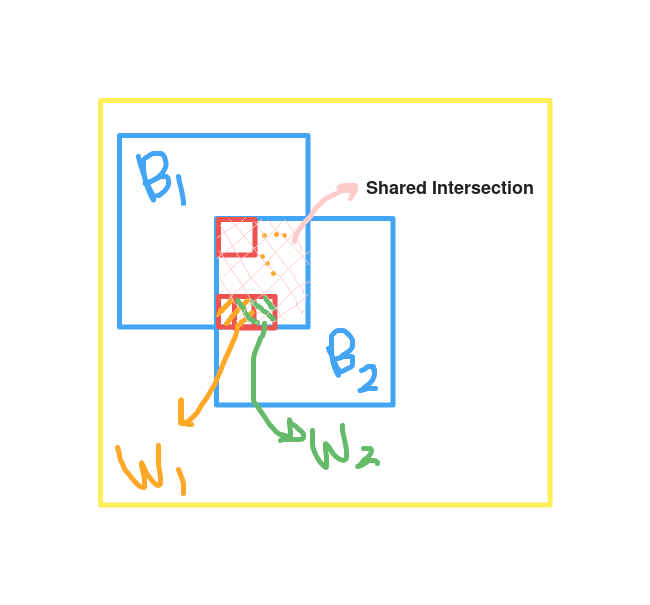

**Why should not we do it once?** This is exactly what Fast R-CNN does.

Instead of of computing the whole conv layers for each region seperately, it does so only once to the whole image. Then, we consider the regions of our interest in the resulting dimension. Check the below image for clarification

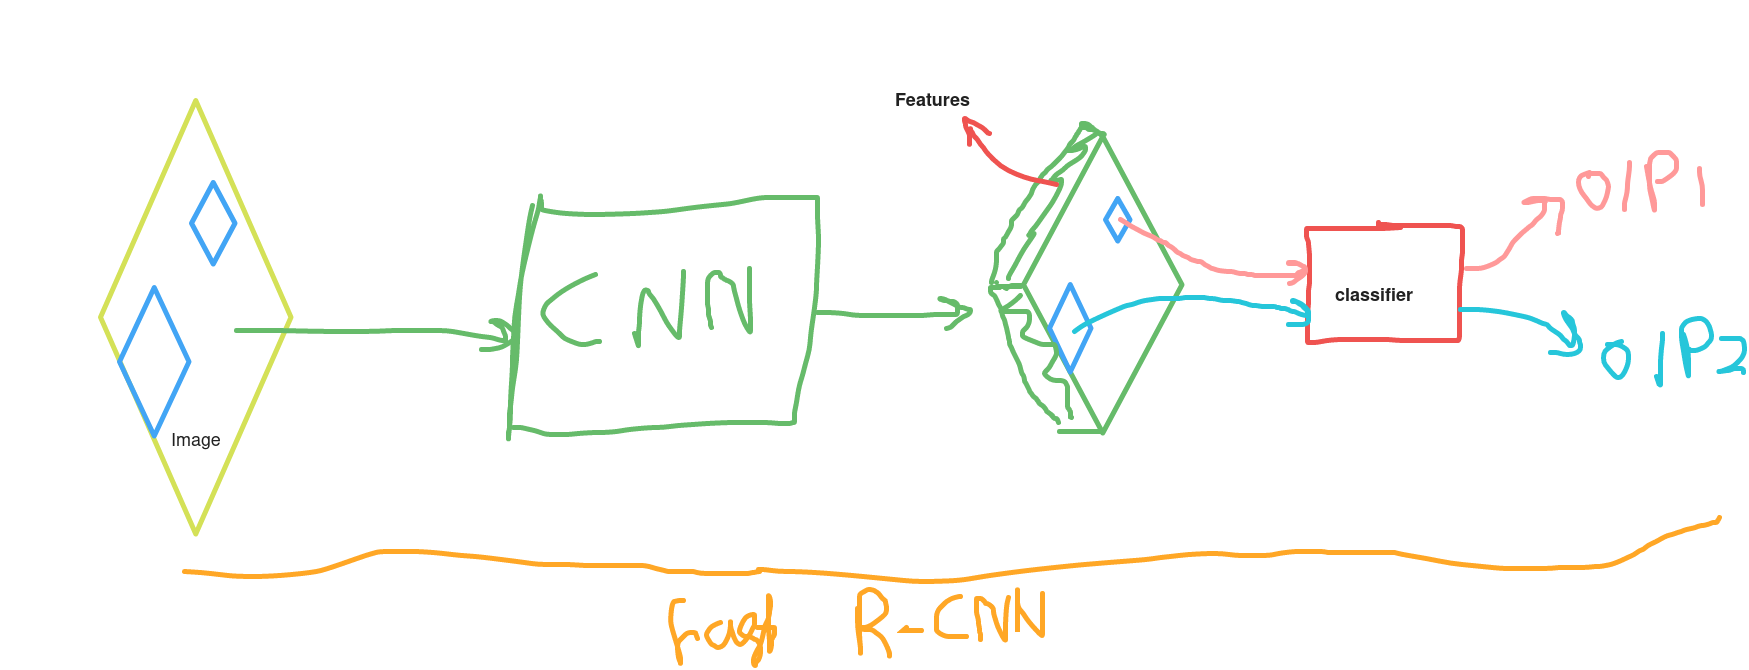

### Region Extraction & Pre-processing

In [ ]:
# ==============================================================================
# Extract the regions of the dataset images
# ------------------------------------------------------------------------------
#   - FPATHS: Image paths
#   -  GTBBS: Bounding Boxes (x1,y1,x2,y2)
#   -   CLSS: true class labels of the boxes
#   - DELTAS: Difference between the generated bounding boxes, and true ones
#   -   ROIS: Region of Interests
# ==============================================================================
FPATHS, GTBBS, CLSS, DELTAS, ROIS, IOUS = [], [], [], [], [], []
N = 500
for ix, (im, bbs, labels, fpath) in enumerate(ds):
    if(ix==N):
        break
    H, W, _ = im.shape
    # --------------------------------------------------------------------------
    # Extract the candidates, but  the generated candidates  are in the  form of
    #     (x,y,width,hight) so we convert them to (x1,y1,x2,y2)
    # --------------------------------------------------------------------------
    candidates = extract_candidates(im)
    candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates])
    ious, rois, clss, deltas = [], [], [], []
    # --------------------------------------------------------------------------
    # Extract the IoUs between the generated regions and the true bounding boxes
    # --------------------------------------------------------------------------
    ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] \
                     for _bb_ in bbs]).T
    for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx]
        best_iou_at = np.argmax(candidate_ious)
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = bbs[best_iou_at]
        # ----------------------------------------------------------------------
        # We define a threshold of 0.3. If it is more, it is a detection, else a
        # background
        # ----------------------------------------------------------------------
        if best_iou > 0.3: clss.append(labels[best_iou_at])
        else : clss.append('background')
        # ----------------------------------------------------------------------
        # compute the difference between the candidate and true position as % 
        # ----------------------------------------------------------------------
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))
    FPATHS.append(fpath)
    IOUS.append(ious)
    ROIS.append(rois)
    CLSS.append(clss)
    DELTAS.append(deltas)
    GTBBS.append(bbs)
FPATHS = [f'{IMAGE_ROOT}/{stem(f)}.jpg' for f in FPATHS] 
FPATHS, GTBBS, CLSS, DELTAS, ROIS = [item for item in [FPATHS, GTBBS, CLSS,
                                                       DELTAS, ROIS]]

In [ ]:
len(DELTAS[0]), len(CLSS[0])

(48, 48)

In [ ]:
# ==============================================================================
# Do target encoding
# ==============================================================================
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']

print("The label to target values dictionary formed is:" ,label2target)

The label to target values dictionary formed is: {'Bus': 0, 'background': 1, 'Truck': 2}


In [ ]:
# ==============================================================================
# normalize the images for better performance
# ==============================================================================
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds

### Dataset Wrapper

In [ ]:
# ==============================================================================
# Create a dataset wrapper for our Fast-RCNN dataset
# ==============================================================================
class FRCNNDataset(Dataset):
    def __init__(self, fpaths, rois, labels, deltas, gtbbs):
        self.fpaths = fpaths
        self.gtbbs = gtbbs
        self.rois = rois
        self.labels = labels
        self.deltas = deltas
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        fpath = str(self.fpaths[ix])
        image = cv2.imread(fpath, 1)[...,::-1]
        gtbbs = self.gtbbs[ix]
        rois = self.rois[ix]
        labels = self.labels[ix]
        deltas = self.deltas[ix]
        assert len(rois) == len(labels) == len(deltas), f'{len(rois)}, \
                                          {len(labels)}, {len(deltas)}'
        return image, rois, labels, deltas, gtbbs, fpath
    # --------------------------------------------------------------------------
    # Define a collate function to be used by the data loader to process a batch
    # --------------------------------------------------------------------------
    def collate_fn(self, batch):
        input, rois, rixs, labels, deltas = [], [], [], [], []
        for ix in range(len(batch)):
            image, image_rois, image_labels, image_deltas, image_gt_bbs, \
                   image_fpath = batch[ix]
            image = cv2.resize(image, (224,224))
            input.append(preprocess_image(image/255.)[None])
            rois.extend(image_rois)
            rixs.extend([ix]*len(image_rois))
            labels.extend([label2target[c] for c in image_labels])
            deltas.extend(image_deltas)
        input = torch.cat(input).to(device)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        labels = torch.Tensor(labels).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, labels, deltas


In [ ]:
# ==============================================================================
# Show the number of images we have: 500
# ==============================================================================
print(len(FPATHS))

500


In [ ]:
# ==============================================================================
# Create a data loader: split 9-1 training vs testing (450,50)
# ==============================================================================
n_train = 9*len(FPATHS)//10
train_ds = FRCNNDataset(FPATHS[:n_train], ROIS[:n_train], CLSS[:n_train],
                        DELTAS[:n_train], GTBBS[:n_train])
test_ds = FRCNNDataset(FPATHS[n_train:], ROIS[n_train:], CLSS[n_train:], 
                       DELTAS[n_train:], GTBBS[n_train:])

train_loader = DataLoader(train_ds, batch_size=2,collate_fn=train_ds.collate_fn,
                          drop_last=True)
test_loader = DataLoader(test_ds, batch_size=2, collate_fn=test_ds.collate_fn,
                         drop_last=True)

### Model

We are using a pretrained model of VGG16 architecture

In [37]:
# ==============================================================================
# Create the model using VGG16 as backbone
# ==============================================================================
class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # ----------------------------------------------------------------------
        # Load the VGG16 and enable training for the network parameters
        # ----------------------------------------------------------------------
        rawnet = torchvision.models.vgg16_bn(pretrained=True)
        for param in rawnet.features.parameters():
            # You can turn it on for fine-tuning
            param.requires_grad = False
        # ----------------------------------------------------------------------
        # To have more control load the layers in the features part into seq var
        # ----------------------------------------------------------------------
        self.seq = nn.Sequential(*list(rawnet.features.children())[:-1])
        # ----------------------------------------------------------------------
        # Define an ROI Pool operation
        # ----------------------------------------------------------------------
        # The bounding boxes are based on the dimension  of the  inputs 224*224,
        # but the output of the sequential feature conv layers produce 14*14, so
        # we define the spatial scale as 14/224.
        # ----------------------------------------------------------------------
        # Furthermore, the layer outputs 7*7 result by applying pooling on these
        # 14*14 feature map
        # ----------------------------------------------------------------------
        self.roipool = RoIPool(7, spatial_scale=14/224)
        feature_dim = 512*7*7
        # ----------------------------------------------------------------------
        # Define a class layer
        # ----------------------------------------------------------------------
        self.cls_score = nn.Linear(feature_dim, len(label2target))
        # ----------------------------------------------------------------------
        # Define a bounding box regressor layers
        # ----------------------------------------------------------------------
        self.bbox = nn.Sequential(
              nn.Linear(feature_dim, 512),
              nn.ReLU(),
              nn.Linear(512, 4),
              nn.Tanh(),
            )
        # ----------------------------------------------------------------------
        # Classification loss
        # ----------------------------------------------------------------------
        self.cel = nn.CrossEntropyLoss()
        # ----------------------------------------------------------------------
        # Regression loss
        # ----------------------------------------------------------------------
        self.sl1 = nn.L1Loss()
    def forward(self, input, rois, ridx):
        # ----------------------------------------------------------------------
        # Do the forward pass
        # ----------------------------------------------------------------------
        res = input
        res = self.seq(res)
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois)
        features = res.view(len(res), -1)
        cls_score = self.cls_score(features)
        bbox = self.bbox(features) # .view(-1, len(label2target), 4)
        return cls_score, bbox
    def calc_loss(self, probs, _deltas, labels, deltas):
        # ----------------------------------------------------------------------
        # Compute the classification loss
        # ----------------------------------------------------------------------
        detection_loss = self.cel(probs, labels)
        # ----------------------------------------------------------------------
        # Now,  compute the  regression loss,  but we care only  about detecting
        # objects; otherwise, we do not really care about what bounding  box the
        # network generates because there is no object.
        # Therefore, we get the indices of the true labels that are objects, not
        # a background (1).
        # ----------------------------------------------------------------------
        ixs, = torch.where(labels != background_class)
        _deltas = _deltas[ixs]
        deltas = deltas[ixs]
        self.lmb = 10.0
        if len(ixs) > 0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, \
                   detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss = 0
            return detection_loss + self.lmb * regression_loss, \
                   detection_loss.detach(), regression_loss

In [38]:
# ==============================================================================
# Define some helper functions for training and validation
# ==============================================================================
def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss.detach(), loc_loss, regr_loss, accs.cpu().numpy()

In [39]:
# ==============================================================================
# create the model, loss, and optimizer
# ==============================================================================
frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = optim.SGD(frcnn.parameters(), lr=1e-3)

In [40]:
# ==============================================================================
# Do the training procedure with 5 epochs while logging
# ==============================================================================
n_epochs = 5
log = Report(n_epochs)
for epoch in range(n_epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, 
                                                      optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')
        
    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(inputs, 
                                                frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                val_regr_loss=regr_loss, 
                val_acc=accs.mean(), end='\r')
        
    log.report_avgs(epoch+1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


EPOCH: 1.000	trn_loss: 1.981	trn_loc_loss: 0.853	trn_regr_loss: 0.113	trn_acc: 0.652	val_loss: 1.746	val_loc_loss: 0.772	val_regr_loss: 0.097	val_acc: 0.746	(412.91s - 1651.65s remaining)
EPOCH: 2.000	trn_loss: 1.478	trn_loc_loss: 0.627	trn_regr_loss: 0.085	trn_acc: 0.757	val_loss: 1.752	val_loc_loss: 0.787	val_regr_loss: 0.096	val_acc: 0.747	(787.16s - 1180.74s remaining)
EPOCH: 3.000	trn_loss: 1.230	trn_loc_loss: 0.537	trn_regr_loss: 0.069	trn_acc: 0.799	val_loss: 1.786	val_loc_loss: 0.788	val_regr_loss: 0.100	val_acc: 0.746	(1164.32s - 776.21s remaining)
EPOCH: 4.000	trn_loss: 1.080	trn_loc_loss: 0.479	trn_regr_loss: 0.060	trn_acc: 0.832	val_loss: 1.781	val_loc_loss: 0.790	val_regr_loss: 0.099	val_acc: 0.745	(1542.87s - 385.72s remaining)
EPOCH: 5.000	trn_loss: 0.968	trn_loc_loss: 0.437	trn_regr_loss: 0.053	trn_acc: 0.851	val_loss: 1.757	val_loc_loss: 0.793	val_regr_loss: 0.096	val_acc: 0.745	(1914.05s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2195.40it/s]


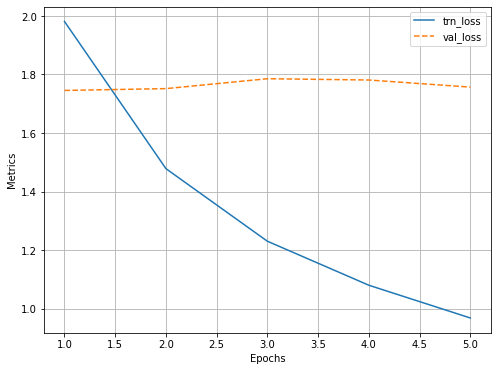

In [41]:
# ==============================================================================
# Plotting training and validation losses
# ==============================================================================
log.plot_epochs('trn_loss,val_loss'.split(','))

100%|██████████| 106/106 [00:00<00:00, 1203.63it/s]


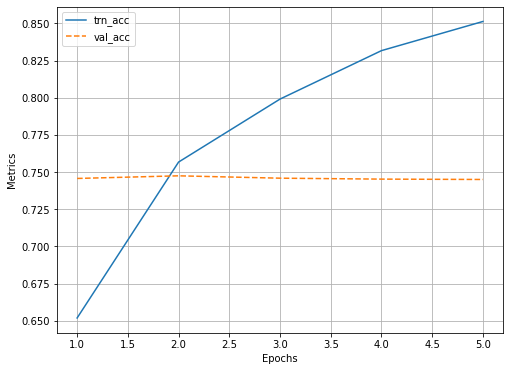

In [42]:
# ==============================================================================
# Plotting training and validation accuracies
# ==============================================================================
log.plot_epochs('trn_acc,val_acc'.split(','))